# Demonstrating sparkmagic

## This notebook will demonstrate how we can use the spark magic to interspere our Python code with code that is running against a Spark cluster

Let’s say we’re working in an IPython notebook and we want to use Spark to analyze some data. So, we'll load `sparkmagic` in order to be able to talk to Spark from our Python notebook.

In [1]:
%load_ext sparkmagic.magics

With it, the `%manage_spark` line magic and the `%%spark` magic are available.

The %%manage_spark line magic lets you manage Livy endpoints and Spark sessions.

Let's start by adding an Endpoint.

An Endpoint is a [Livy](https://github.com/cloudera/livy) installation running on a Spark cluster. 

`sparkmagic` allows us to specify the Livy endpoint along with a username and password to authenticate to it. If the Livy endpoint is on your local machine or has no password, simply leave the text fields for username and password blank.

In [2]:
%manage_spark

MagicsControllerWidget(children=(Tab(children=(ManageSessionWidget(children=(HTML(value='<br/>'), HTML(value='…

Added endpoint http://localhost:8998
Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,None,pyspark,idle,,,✔


SparkSession available as 'spark'.


![add_endpoint](images/addendpoint.PNG)

Now, add a session to the endpoint you added. The name you give to the session will be used with the `%%spark` magic to run Spark code. You can also specify the configuration you want to start the session with. You can create either Python (PySpark) or Scala (Spark) sessions.

Creating a session will create a `SparkContext` with the name `sc` and a `HiveContext` with the name `sqlContext`.

We'll start by adding a PySpark session.

![add_session](images/addsession.PNG)

You can now run Spark code against your Livy session.  For information on the available commands, run %spark?

In [3]:
%spark?

## Pyspark

You can run code against your Spark session by adding `%%spark` at the beginning of the cell.  Since we’ve only created a single session, we don’t need to specify the session name.

In the following cell, I'll create a Resilient Distributed Dataset (RDD) called fruits, and print its first element.

In [3]:
%%spark
numbers = sc.parallelize([1, 2, 3, 4])
print('First element of numbers is {} and its description is:\n{}'.format(numbers.first(), numbers.toDebugString()))

First element of numbers is 1 and its description is:
b'(1) ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:194 []'

Now, you've created your session and executed some statements. If you want to look at the Livy logs for this session, simply run a cell like so:

In [5]:
%spark logs

16/06/09 23:43:28 WARN SparkConf: The configuration key 'spark.yarn.applicationMaster.waitTries' has been deprecated as of Spark 1.3 and and may be removed in the future. Please use the new key 'spark.yarn.am.waitTime' instead.
16/06/09 23:43:28 WARN SparkConf: The configuration key 'spark.yarn.applicationMaster.waitTries' has been deprecated as of Spark 1.3 and and may be removed in the future. Please use the new key 'spark.yarn.am.waitTime' instead.
16/06/09 23:43:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/09 23:43:30 INFO TimelineClientImpl: Timeline service address: http://localhost:8188/ws/v1/timeline/
16/06/09 23:43:30 INFO Client: Requesting a new application from cluster with 10 NodeManagers
16/06/09 23:43:30 INFO Client: Verifying our application has not requested more than the maximum memory capability of the cluster (25600 MB per container)
16/06/09 23:43:30 INFO Client: Will allocate 

## SparkSQL

You can run SQL queries by passing the arguments `-c sql` to the %%spark magic

First, let's create a table:

In [3]:
%%spark
df = spark.read.json("/apps/spark-2.3.3/examples/src/main/resources/people.json")
df.createOrReplaceTempView("people")

Now we can see what tables we have:

In [4]:
%%spark -c sql
SHOW TABLES

,database,tableName,isTemporary
0,NaT,people,True


Now, let's query one of the available tables.

Notice that we are passing the `--output` or `-o` parameter with a value of `df_hvac` so that the output of our SQL query is saved in the `df_hvac` variable in the IPython kernel context as a [Pandas](http://pandas.pydata.org/) DataFrame.

In [5]:
%%spark -c sql -o df_people --maxrows 10
SELECT * FROM people

,age,name
0,NaN,Michael
1,30.0,Andy
2,19.0,Justin


>SQL queries also have other parameters you can pass in, like `--samplemethod`, `--maxrows`, `--samplefraction`, and `--quiet`.

We can now simply use the Pandas dataframe from the IPython notebook.

In [6]:
df_people.head()

,age,name
0,NaN,Michael
1,30.0,Andy
2,19.0,Justin


If you want to visualize the data in the Pandas dataframe, you can write your own code to do so, or you can use our autovisualization widget:

In [6]:
from autovizwidget.widget.utils import display_dataframe
display_dataframe(df_people)

/home/itamarst/Devel/sparkmagic/autovizwidget/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

AutoVizWidget()

>You could also choose to have this widget display by default for *all* Pandas dataframes from here on by running this piece of code:

```
ip = get_ipython()
ip.display_formatter.ipython_display_formatter.for_type_by_name('pandas.core.frame', 'DataFrame', display_dataframe)
```

### Server-side rendering

You can also have images rendered on the server, and then display them locally. This prevents the need to ship large amounts of data locally to do visualizations. First, we render a PNG, in this case using matplotlib:

In [13]:
%%spark
import matplotlib.pyplot as plt
ax = df.toPandas().plot.bar(x='name',y='age')

And now we can view the resulting image using the `%matplot` magic:

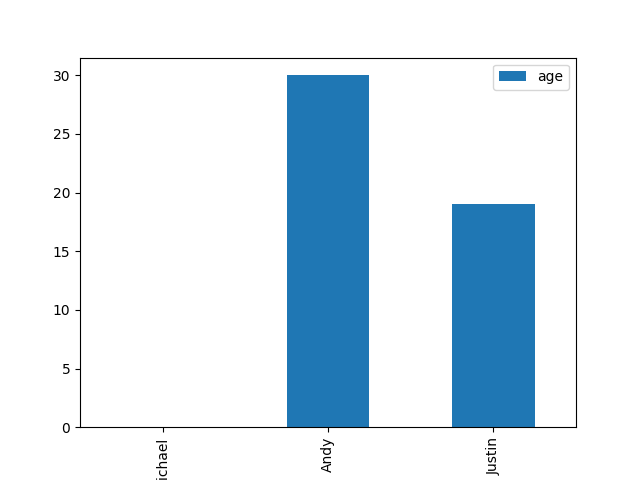

In [14]:
%%spark
%matplot plt

## Scala support

If you want to write your Spark code in Scala, you can easily do that.

Let's add a Scala session:

In [10]:
%manage_spark

Creating SparkContext as 'sc'
Creating HiveContext as 'sqlContext'


![add_session](images/addsession_s.PNG)

And just run some Spark code. Notice that we now specify the session we want to use, `-s my_spark`.

In [12]:
%%spark -s my_spark
val hvacText = sc.parallelize(Array(1, 2, 3, 4))
hvacText.first()

res0: Int = 1

Now, we can query the table with **SparkSQL** too:

In [13]:
%%spark -s my_spark -c sql -o my_df_from_scala --maxrows 10
SELECT * FROM hivesampletable

,clientid,country,devicemake,devicemodel,deviceplatform,market,querydwelltime,querytime,sessionid,sessionpagevieworder,state
0,8,United States,Samsung,SCH-i500,Android,en-US,13.920401,2016-06-09 18:54:20,0,0,California
1,23,United States,HTC,Incredible,Android,en-US,NaN,2016-06-09 19:19:44,0,0,Pennsylvania
2,23,United States,HTC,Incredible,Android,en-US,1.475742,2016-06-09 19:19:46,0,1,Pennsylvania
3,23,United States,HTC,Incredible,Android,en-US,0.245968,2016-06-09 19:19:47,0,2,Pennsylvania
4,28,United States,Motorola,Droid X,Android,en-US,20.309534,2016-06-09 01:37:50,1,1,Colorado
5,28,United States,Motorola,Droid X,Android,en-US,16.298167,2016-06-09 00:53:31,0,0,Colorado
6,28,United States,Motorola,Droid X,Android,en-US,1.771523,2016-06-09 00:53:50,0,1,Colorado
7,28,United States,Motorola,Droid X,Android,en-US,11.675599,2016-06-09 16:44:21,2,1,Utah
8,28,United States,Motorola,Droid X,Android,en-US,36.944689,2016-06-09 16:43:41,2,0,Utah
9,28,United States,Motorola,Droid X,Android,en-US,28.981142,2016-06-09 01:37:19,1,0,Colorado


And we can still access the result of the Spark query from Scala as a Pandas dataframe!

In [14]:
my_df_from_scala.head()

,clientid,country,devicemake,devicemodel,deviceplatform,market,querydwelltime,querytime,sessionid,sessionpagevieworder,state
0,8,United States,Samsung,SCH-i500,Android,en-US,13.920401,2016-06-09 18:54:20,0,0,California
1,23,United States,HTC,Incredible,Android,en-US,NaN,2016-06-09 19:19:44,0,0,Pennsylvania
2,23,United States,HTC,Incredible,Android,en-US,1.475742,2016-06-09 19:19:46,0,1,Pennsylvania
3,23,United States,HTC,Incredible,Android,en-US,0.245968,2016-06-09 19:19:47,0,2,Pennsylvania
4,28,United States,Motorola,Droid X,Android,en-US,20.309534,2016-06-09 01:37:50,1,1,Colorado


# Cleaning up

Now that you’re done with your Livy sessions, you should clean them up.

Simply click on the `Delete` buttons!

In [15]:
%manage_spark

![clean_up](images/cleanup.PNG)